# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Seinfeld Script Generator

Notebook 2: Data Cleaning & EDA

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

In [77]:
# set the display to maximum for easy review of the data

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [78]:
scripts = pd.read_csv('../data/scripts_no_title.csv')
scripts.head()

,character,line,episode
0,JERRY,"You know, why we're here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about ""We should go out""? This is what they're talking about...this whole thing, we're all out now, no one is home. Not one person here is home, we're all out! There are people tryin' to find us, they don't know where we are. (imitates one of these people ""tryin' to find us""; pretends his hand is a phone) ""Did you ring?, I can't find him."" (imitates other person on phone) ""Where did he go?"" (the first person again) ""He didn't tell me where he was going"". He must have gone out. You wanna go out: you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...There you're staring around, whatta you do? You go: ""We gotta be getting back"". Once you're out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, it's my feeling, you've gotta go. (Pete's luncheonette. Jerry and George are sitting at a table.)","GOOD NEWS, BAD NEWS"
1,JERRY,"Seems to me, that button is in the worst possible spot. (talking about George's shirt) The second button literally makes or breaks the shirt, look at it: it's too high! It's in no-man's-land, you look like you live with your mother.","GOOD NEWS, BAD NEWS"
2,GEORGE,Are you through? (kind of irritated),"GOOD NEWS, BAD NEWS"
3,JERRY,"You do of course try on, when you buy?","GOOD NEWS, BAD NEWS"
4,GEORGE,"Yes, it was purple, I liked it, I don't actually recall considering the buttons.","GOOD NEWS, BAD NEWS"


In [79]:
scripts.shape

(54211, 3)

Our data has 54,211 rows with 3 features.

### Data Cleaning

Thanks to the scraper built in the previous notebook, the scripts data is fairly clean. Each datapoint consists of three features: the character who was speaking, the corresponding line and the episode name. Upon inital examining, there were no null values or mismatched data types. 

In [80]:
# check null value just in case

scripts.isnull().sum()

character    0
line         0
episode      0
dtype: int64

In [81]:
# check data types

scripts.dtypes

character    object
line         object
episode      object
dtype: object

However, as I further investigated the data, some issues with the data surfaced: 1. there were typos of names in the character columns (i.e: Kramer spelled as "KRAMERT"); 2. inconsistancies in names for each character(i.e: "E", "ElAINE" both refer to as Elaine); 3. some cells in character columns were locations, or actions, not the characters (i.e: "JERRY MOCKING", "INT. MEETING ROOM - DAY"); 4. some lines were spoken by more than one character; 5. there were special characters (i.e: "-----" or "======").

In order to reduce the complication of the model, following strategies were used to fix the above issues and clean the data:
1. remove datapoints that have less than  occurance because these data are not likely to provide any valuable inference for the model

In [82]:
occurrence = scripts.value_counts('character', ascending = True)
drop_rows = list(occurrence[occurrence<=10].index)

drop_index=[]
for row in drop_rows:
    ids = list(scripts[scripts['character'] == row].index)
    for i in ids:
        drop_index.append(i)
        
scripts.drop(drop_index, inplace=True)

scripts.reset_index(drop=True, inplace=True)

2. correct typos, redundant character names 

In [83]:
scripts['character'] = ['KRAMER' if i == 'KRAMER,' else i for i in scripts['character']]

In [84]:
scripts['character'] = ['JERRY' if i == 'JERRY,' else i for i in scripts['character']]

In [85]:
scripts['character'] = ['UNCLE LEO' if i == 'LEO' else i for i in scripts['character']]

In [86]:
scripts['character'] = ['JOE DAVOLA' if i == 'JOE DIVOLA' else i for i in scripts['character']]

In [87]:
scripts['character'] = ['WOMAN' if i == 'WOMEN' else i for i in scripts['character']]

3. correct misplaced lines due to the wrong formatting of the data source

In [88]:
for i in list(scripts[scripts.character == 'I'].index):
    scripts.iloc[i-1, 1] = scripts.iloc[i-1, 1] + ' ' + scripts.iloc[i, 0] + ' ' + scripts.iloc[i, 1]
    scripts.drop(i, inplace=True)

4. drop rows where dedicated to two speakers

In [89]:
scripts.drop(list(scripts[scripts['character'] == 'JERRY AND ELAINE'].index), inplace=True)

Moreover, there are 180 aired episodes for <em>Seinfeld</em>, however only 174 unique episodes were collected. This is because: 1. the data didn't include the four clip/highlight episodes - S6E14-E15 "The Highlights of 100", S9E21-E22 "The Clip Show"; 2. the website mislinked two of the regular episodes - S6E1 "The Chaperone" to "The Opposite", S6E7 "The Soup" to "The Soup Nazi", which results in the latter two episodes to have duplicate input in the data. I therefore decide to drop those duplicate rows.

In [90]:
len(scripts.episode.unique())

174

In [91]:
scripts.drop_duplicates(subset=['line'], inplace=True)

Our cleaned data now has 44,661 rows and 3 features.

In [92]:
scripts.shape

(44661, 3)

### Feature Engineering

Next I engineered a couple features including a word count column and a column that combines the character name and the corresponding line. The word count is a standard NLP technique for EDA purpose. As far as the char_line column goes, it would be used to as the finalized data for modeling.

In [93]:
# create word counts for each line 

def word_count(line):
    
    splited = line.split()
    final = []
    for chunk in splited:
        if '...' in chunk:
            chunk = chunk.split('...')
            for i in chunk:
                final.append(i)
        else:
            final.append(chunk)

    return len(final)

scripts['word_count'] = scripts['line'].map(word_count)

In [94]:
# concatenate the columns 

scripts['char_line'] = (scripts['character'] + ': ' + scripts['line'])

# convert to lowercase

scripts['char_line'] = scripts['char_line'].map(lambda x: x.lower())

### Exploratory Data Analysis

Line and Word Counts

First I looked at the line and word counts by episode. The average is 258 lines while the maximum number is 660, which is more than twice the average. This seesm unusual because the show ran the same length for each episode. Upon checking it was the episode "THE RAINCOAT PART 1" which contains the scripts of two episodes. Same case with word counts. 

In [95]:
scripts.groupby('episode')['line'].count().describe()

count    173.000000
mean     258.156069
std      49.411348 
min      84.000000 
25%      234.000000
50%      253.000000
75%      284.000000
max      660.000000
Name: line, dtype: float64

In [96]:
scripts.groupby('episode')['word_count'].sum().describe()

count    173.000000 
mean     3281.710983
std      773.576508 
min      1301.000000
25%      2851.000000
50%      3120.000000
75%      3535.000000
max      7722.000000
Name: word_count, dtype: float64

Overall the average word count per line is 13 words. The distribution of the word count per line is highly skewed to the right. The max number is 399, which is not to my surprise, considering that the show always start with Jerry Seinfeld doing a comedy stand up which has long lines. These information would be a good reference for my modeling when deciding how many previous words I should have the model look at.

In [97]:
scripts['word_count'].describe()

count    44661.000000
mean     12.712120   
std      14.094143   
min      1.000000    
25%      5.000000    
50%      9.000000    
75%      16.000000   
max      399.000000  
Name: word_count, dtype: float64

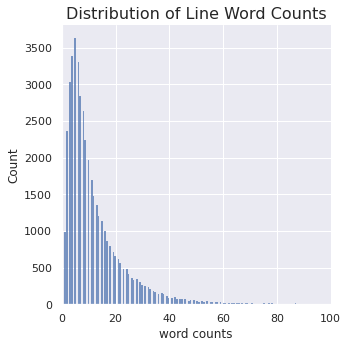

In [98]:
sns.displot(scripts['word_count'], height=5, kind='hist', palette='coolwarm')
plt.title('Distribution of Line Word Counts', fontsize=16)
plt.xlim((0, 100))
plt.xlabel('word counts')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../charts/dist_word_counts.png');

Next I moved on to looking at the line and word counts by character. Not surprisingly, the four leading characters have the most lines and words in the script.

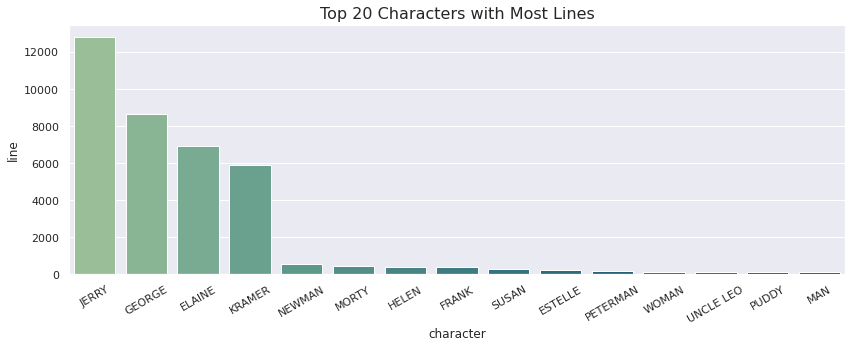

In [99]:
plt.figure(figsize = (12,5))
plt.title('Top 20 Characters with Most Lines', fontsize=16)
sns.barplot(x= scripts.groupby('character')['line'].count().sort_values(ascending = False)[:15].index, 
            y = scripts.groupby('character')['line'].count().sort_values(ascending = False)[:15],
            palette = 'crest')
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/top15_most_lines.png');

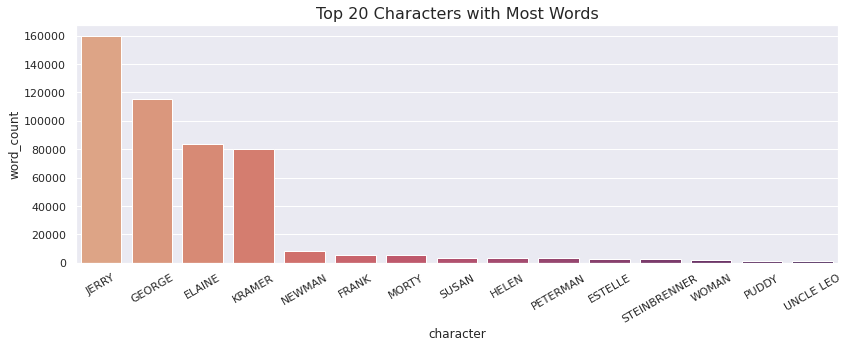

In [100]:
plt.figure(figsize = (12,5))
plt.title('Top 20 Characters with Most Words', fontsize=16)
sns.barplot(x = scripts.groupby('character')['word_count'].sum().sort_values(ascending = False)[:15].index,
            y = scripts.groupby('character')['word_count'].sum().sort_values(ascending = False)[:15],
            palette = 'flare')
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/top15_most_words.png');

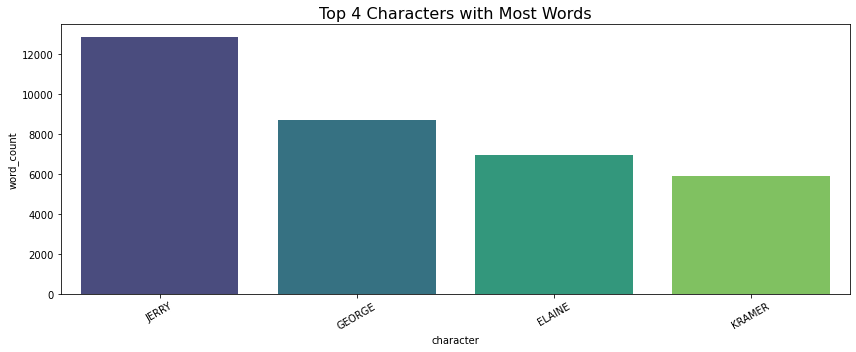

In [26]:
plt.figure(figsize = (12,5))
plt.title('Top 4 Characters with Most Words', fontsize=16)
sns.barplot(x= scripts.groupby('character')['word_count'].count().sort_values(ascending = False)[:4].index, 
            y = scripts.groupby('character')['word_count'].count().sort_values(ascending = False)[:4],
            palette = 'viridis')
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/top4_most_words.png');

In [27]:
scripts[(scripts['character'] == "JERRY") 
        | (scripts['character'] == "ELAINE") 
        | (scripts['character'] == "GEORGE")
        | (scripts['character'] == "KRAMER")]['word_count'].describe()

count    34339.000000
mean     12.789598   
std      14.142894   
min      1.000000    
25%      5.000000    
50%      9.000000    
75%      16.000000   
max      371.000000  
Name: word_count, dtype: float64

Sentiment Analysis

In [28]:
def sentiment(text):
    sentiment = SentimentIntensityAnalyzer()
    score = sentiment.polarity_scores(text)
    return score['compound']

scripts['sentiment_score'] = scripts['line'].map(sentiment)

In [29]:
def convert_sen(num):
    if num > 0:
        return 'positive'
    elif num == 0:
        return 'neutral'
    else:
        return 'negative'
    
scripts['sentiment'] = scripts['sentiment_score'].map(convert_sen)

In [30]:
char = ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER', 'FRANK', 'MORTY', 'HELEN', 'SUSAN', 'ESTELLE', 'NEWMAN']

for name in char:
    scripts[scripts.character == name].groupby(['character', 'sentiment'])['sentiment_score'].count()

In [31]:
sentiment_counts = scripts[(scripts.character == 'GEORGE') | (scripts.character == 'KRAMER') | (scripts.character == 'ELAINE') | (scripts.character == 'JERRY')].groupby(['character', 'sentiment'])['sentiment_score'].count()

In [32]:
sent_by_top4 = pd.DataFrame(sentiment_counts)
sent_by_top4.groupby('character').transform(lambda x: x/x.sum())

sentiment_score
character sentiment                 
ELAINE    negative   0.189893       
          neutral    0.468615       
          positive   0.341492       
GEORGE    negative   0.194931       
          neutral    0.450576       
          positive   0.354493       
JERRY     negative   0.194232       
          neutral    0.475448       
          positive   0.330320       
KRAMER    negative   0.183580       
          neutral    0.417474       
          positive   0.398946

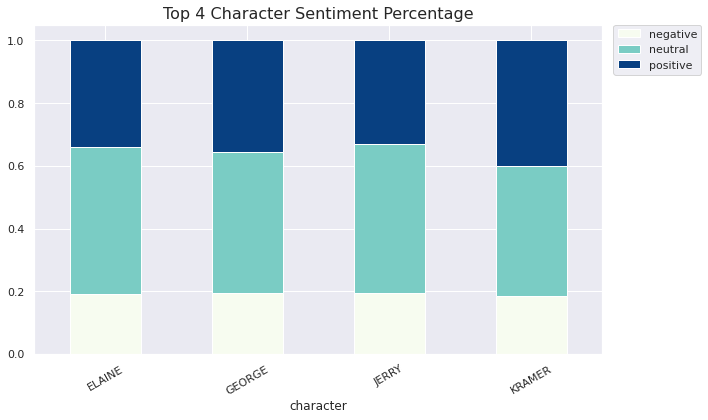

In [33]:
sns.set()
sent_by_top4.groupby('character').transform(lambda x: x/x.sum()).unstack('sentiment').plot.bar(figsize=(10, 6), 
                                                                                               stacked=True, 
                                                                                               colormap='GnBu')
plt.title('Top 4 Character Sentiment Percentage', fontsize=16)                                                                                    
# code to change position of legends from: https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
plt.legend(['negative', 'neutral', 'positive'], bbox_to_anchor=(1.02, 1.0), loc=2, borderaxespad=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../charts/top4_sentiment_percentage.png');

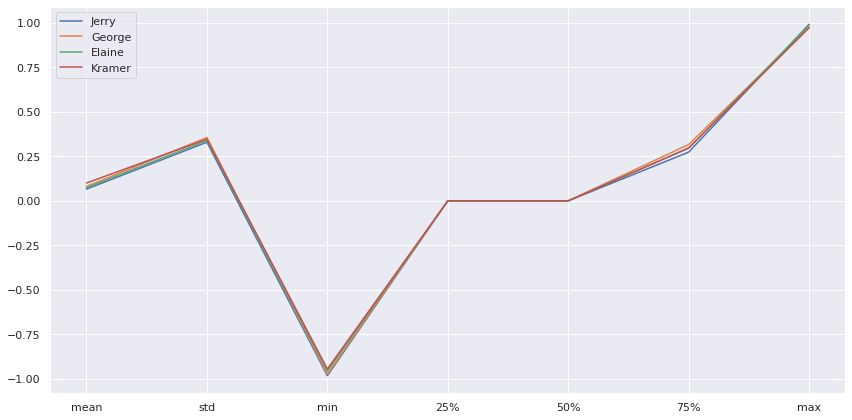

In [34]:
plt.figure(figsize = (12, 6))
plt.plot(scripts[scripts.character == 'JERRY']['sentiment_score'].describe()[1:], label='Jerry')
plt.plot(scripts[scripts.character == 'GEORGE']['sentiment_score'].describe()[1:], label='George')
plt.plot(scripts[scripts.character == 'ELAINE']['sentiment_score'].describe()[1:], label='Elaine')
plt.plot(scripts[scripts.character == 'KRAMER']['sentiment_score'].describe()[1:], label='Kramer')
plt.legend()
plt.tight_layout()
plt.savefig('../charts/top4_sentiment_describe.png');

Content Analysis

Preprocessing to remove all the description text within the parenthethis

In [35]:
def remove_par(text):
    text = re.sub('\((.*?)\)', '', text)
    return text

scripts['line_no_par'] = scripts['line'].map(remove_par)

Most common words by characters without custom stop words

In [36]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

know      1151
don       1036
oh        898 
just      802 
like      776 
yeah      770 
george    569 
ll        568 
jerry     565 
hey       536 
elaine    529 
kramer    529 
right     523 
got       518 
think     512 
did       451 
want      408 
going     401 
good      362 
really    362 
dtype: int64

In [37]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

oh        799
know      635
jerry     514
yeah      509
just      496
don       451
george    331
like      310
right     309
kramer    292
got       278
elaine    264
think     262
ll        243
did       240
hey       240
really    239
uh        239
going     222
mean      199
dtype: int64

In [38]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

know      847
don       631
like      605
jerry     582
just      576
oh        558
yeah      511
right     450
uh        419
think     405
george    384
got       384
ll        366
hey       316
tell      282
good      280
really    276
going     274
gonna     271
kramer    271
dtype: int64

In [39]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

yeah      855
jerry     687
oh        629
know      539
hey       442
got       392
don       382
kramer    348
uh        339
right     323
ll        315
just      311
like      298
george    294
look      269
gonna     243
elaine    220
come      200
going     192
think     167
dtype: int64

Most common bigram

In [40]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

don know           265
don want           104
don think          79 
oh yeah            68 
ve got             65 
wait second        62 
oh god             59 
ll tell            52 
oh hi              44 
yeah yeah          42 
jerry apartment    41 
uncle leo          40 
hey hey            37 
didn know          36 
don understand     34 
kramer enters      33 
ve seen            33 
coffee shop        32 
yeah right         29 
oh don             28 
dtype: int64

In [41]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

don know           107
oh god             63 
ha ha              57 
oh yeah            53 
ve got             50 
yeah yeah          48 
don want           43 
don think          40 
mr peterman        37 
mr pitt            34 
oh oh              31 
oh come            31 
jerry apartment    28 
yeah right         26 
know just          26 
jerry jerry        25 
ll just            25 
oh hi              24 
kramer enters      23 
oh don             21 
dtype: int64

In [42]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))


X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

don know           145
yeah yeah          60 
don think          55 
ha ha              45 
oh god             43 
wait minute        42 
don want           41 
hey hey            41 
ll tell            40 
oh yeah            40 
jerry apartment    38 
ve got             34 
right right        31 
jerry george       28 
new scene          28 
don like           27 
let just           26 
kramer enters      24 
yes yes            24 
did say            23 
dtype: int64

In [43]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

oh yeah            125
yeah yeah          106
don know           59 
don want           39 
hey hey            39 
ve got             38 
hey jerry          38 
wait wait          33 
ll tell            29 
oh hey             27 
jerry george       25 
oh come            24 
jerry apartment    24 
uh uh              23 
new scene          22 
come jerry         22 
yeah know          22 
don think          21 
yeah uh            20 
hey buddy          20 
dtype: int64

Most common trigrams

In [44]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

hello oh hi              21
new scene jerry          12
second wait second       12
wait second wait         12
don know just            11
hey hey hey              10
wait wait wait           8 
let ask question         8 
phone rings jerry        8 
oh don know              8 
hi jerry seinfeld        7 
ll tell ya               7 
oh yeah right            7 
don know got             7 
sagman bennet robbins    7 
don think gonna          6 
don know maybe           6 
know don know            6 
oh wait second           6 
new scene elaine         6 
dtype: int64

In [45]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

ha ha ha                  28
oh oh oh                  8 
don know don              7 
new scene jerry           7 
know don know             6 
oh god oh                 5 
minute wait minute        5 
guess ll just             5 
wait minute wait          5 
oh don know               5 
don know just             5 
oh yeah right             5 
oh yeah yeah              4 
yeah yeah ll              4 
oh come jerry             4 
oh yeah sure              4 
oh don think              4 
jerry apartment kramer    3 
don know mean             3 
don want don              3 
dtype: int64

In [46]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))


X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

ha ha ha                  14
new scene jerry           14
hey hey hey               13
wait minute wait          11
yeah yeah yeah            10
minute wait minute        10
la la la                  7 
ho ho ho                  7 
new scene kramer          6 
let ask question          5 
jerry apartment jerry     5 
uh don know               5 
opens kramer enters       5 
new scene elaine          5 
george george costanza    5 
oh yeah sure              5 
oh oh oh                  5 
don know don              5 
ll tell don               5 
door opens kramer         5 
dtype: int64

In [47]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = 'english',
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

oh yeah yeah               28
wait wait wait             17
hey hey hey                15
yeah yeah yeah             14
ho ho ho                   9 
new scene jerry            8 
oh come jerry              8 
coffee table book          7 
little jerry seinfeld      6 
kramer heads door          5 
ll tell ll                 5 
yeah yeah got              5 
pretzels making thirsty    4 
oh yeah got                4 
oh oh oh                   4 
oh don think               4 
scene jerry apartment      4 
super terrific happy       4 
new scene george           4 
yeah yeah uh               4 
dtype: int64

With custom stop words

In [48]:
stop_words_uni = [x for x in ENGLISH_STOP_WORDS]
additional = ['yeah', 'oh', 'hey', 'll', 'jerry', 'kramer', 'george', 'elaine', 'did', 've', 'got']
for word in additional:
    stop_words_uni.append(word)

In [49]:
stop_words_bi = [x for x in ENGLISH_STOP_WORDS if x != 'get' and x != 'out']
additional = ['yeah', 'oh', 'hey', 'll', 'jerry', 'kramer', 'george', 'elaine', 'did', 've']
for word in additional:
    stop_words_bi.append(word)

In [50]:
stop_words_tri = [x for x in ENGLISH_STOP_WORDS if x != 'get' and x != 'out' and x != 'a']
additional = ['yeah', 'oh', 'hey', 'll', 'jerry', 'kramer', 'george', 'elaine', 'did', 've']
for word in additional:
    stop_words_tri.append(word)

In [51]:
everybody = scripts['line_no_par'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000, 
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(everybody)

everybody_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

everybody_stop.sum().sort_values(ascending = False).head(25)

don know          693
don want          274
don think         250
get out           236
ha ha             201
new scene         114
don like          113
don understand    106
yes yes           105
right right       105
gonna get         104
wait minute       104
wait second       100
didn know         100
coffee shop       100
gotta get         98 
know just         95 
look like         92 
looks like        85 
know don          84 
let get           83 
new york          83 
don get           81 
don worry         81 
uh uh             79 
dtype: int64

In [52]:
everybody = scripts['line_no_par'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000, 
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(everybody)

everybody_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

everybody_stop.sum().sort_values(ascending = False).head(25)

ha ha ha               93
wait wait wait         30
new scene apartment    28
wait minute wait       24
don know don           24
don know just          23
minute wait minute     22
know don know          21
ho ho ho               19
wait second wait       18
door opens enters      17
let ask question       17
second wait second     16
del boca vista         16
coffee table book      15
get hell out           14
don know got           14
don know gonna         14
get out get            13
don want get           13
don know maybe         13
out get out            13
uh don know            12
phone rings answers    12
yada yada yada         12
dtype: int64

In [53]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

know      1151
don       1036
just      802 
like      776 
right     523 
think     512 
want      408 
going     401 
really    362 
good      362 
gonna     355 
look      317 
come      314 
guy       304 
didn      292 
uh        290 
little    268 
tell      260 
thing     254 
mean      248 
dtype: int64

In [54]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

know      635
just      496
don       451
like      310
right     309
think     262
really    239
uh        239
going     222
mean      199
gonna     183
look      179
come      169
want      168
good      167
didn      152
tell      148
okay      148
guy       144
hi        137
dtype: int64

In [55]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

know      847
don       631
like      605
just      576
right     450
uh        419
think     405
tell      282
good      280
really    276
going     274
gonna     271
didn      210
want      207
let       207
look      206
yes       201
guy       195
say       194
time      183
dtype: int64

In [56]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = stop_words_uni,
                       min_df = 2,
                       max_features = 2000)

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

know       539
don        382
uh         339
right      323
just       311
like       298
look       269
gonna      243
come       200
going      192
want       167
think      167
let        148
good       143
man        136
huh        132
gotta      128
newman     125
alright    123
guy        119
dtype: int64

In [57]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

don know          265
don want          104
don think         79 
get out           71 
wait second       62 
uncle leo         40 
didn know         36 
don understand    34 
going out         34 
coffee shop       32 
gotta get         31 
don get           30 
know just         27 
don care          27 
new scene         27 
right right       25 
looks like        25 
hello hi          25 
gonna get         25 
look like         25 
dtype: int64

In [58]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

don know          107
ha ha             57 
don want          43 
don think         40 
mr peterman       37 
get out           35 
mr pitt           34 
know just         26 
didn know         20 
wait minute       19 
yes yes           18 
don understand    17 
coffee shop       17 
don like          17 
going out         17 
don just          16 
uh uh             14 
know really       14 
mr lippman        14 
jean paul         14 
dtype: int64

In [59]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

don know          146
don think         55 
get out           52 
ha ha             45 
wait minute       42 
don want          41 
right right       31 
gonna get         29 
new scene         28 
don like          27 
let just          26 
gotta get         25 
yes yes           25 
ho ho             23 
didn know         23 
look like         22 
don understand    22 
know like         21 
know just         21 
coffee shop       20 
dtype: int64

In [60]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = stop_words_bi,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(2, 2))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

don know        59
don want        39
wait wait       33
uh uh           30
new scene       22
gonna get       21
don think       21
yes yes         20
get out         20
right right     18
coffee table    18
new york        16
know gonna      15
ho ho           15
let get         15
don like        15
gotta get       15
years ago       14
know got        14
check out       14
dtype: int64

In [61]:
jerry = scripts[scripts['character'] == 'JERRY'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(jerry['line_no_par'])

jerry_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

jerry_stop.sum().sort_values(ascending = False).head(20)

second wait second          12
wait second wait            12
don know just               11
wait wait wait              8 
let ask question            8 
door opens enters           7 
sagman bennet robbins       7 
don know got                7 
new scene apartment         7 
don think gonna             6 
robbins oppenheim taft      6 
know don know               6 
bennet robbins oppenheim    6 
ha ha ha                    6 
don know maybe              6 
don want hear               5 
let get out                 5 
phone rings answers         5 
mother fur coat             5 
don know like               5 
dtype: int64

In [62]:
elaine = scripts[scripts['character'] == 'ELAINE'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(elaine['line_no_par'])

elaine_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

elaine_stop.sum().sort_values(ascending = False).head(20)

ha ha ha               28
don know don           7 
know don know          6 
minute wait minute     5 
don know just          5 
wait minute wait       5 
jean paul jean         4 
paul jean paul         4 
looks exactly like     3 
having good time       3 
taken taken taken      3 
sue ellen mishke       3 
sue ellen mischke      3 
don know think         3 
guess just get         3 
don know means         3 
don know mean          3 
don know going         3 
don want don           3 
doctor writes stuff    3 
dtype: int64

In [63]:
george = scripts[scripts['character'] == 'GEORGE'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(george['line_no_par'])

george_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

george_stop.sum().sort_values(ascending = False).head(20)

ha ha ha                14
wait minute wait        11
minute wait minute      10
new scene apartment     9 
la la la                7 
ho ho ho                7 
door opens enters       6 
gonna get out           5 
uh don know             5 
let ask question        5 
get hell out            5 
don know don            5 
new york yankees        4 
doesn look like         4 
couldn help notice      4 
called running outta    4 
yes yes know            4 
don know tell           4 
don know just           4 
yada yada yada          4 
dtype: int64

In [64]:
kramer = scripts[scripts['character'] == 'KRAMER'].copy()

cvec = CountVectorizer(stop_words = stop_words_tri,
                       min_df = 2,
                       max_features = 2000,
                       ngram_range=(3, 3))

X_stop = cvec.fit_transform(kramer['line_no_par'])

kramer_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

kramer_stop.sum().sort_values(ascending = False).head(20)

wait wait wait             17
ho ho ho                   9 
coffee table book          7 
new scene apartment        6 
super terrific happy       4 
pretzels making thirsty    4 
don know got               3 
look don look              3 
minute wait minute         3 
know really like           3 
boy cable boy              3 
hold second got            3 
friend bob sacamano        3 
terrific happy hour        3 
cable boy cable            3 
gonna check out            3 
gonna throw out            3 
table book coffee          3 
know gonna gonna           3 
uh okay uh                 3 
dtype: int64

For Fun

In [65]:
soup_nazi = scripts[scripts['character'] == 'SOUP NAZI'].copy()

cvec = CountVectorizer(stop_words=stop_words_tri,
                       min_df=2,
                       max_features=2000, 
                       ngram_range=(1, 3))

X_stop = cvec.fit_transform(soup_nazi['line_no_par'])

soup_nazi_stop = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

soup_nazi_stop.sum().sort_values(ascending = False).head(15)

soup                    6
good                    3
year                    2
wild mushroom           2
wild                    2
want                    2
right                   2
recipe wild mushroom    2
recipe wild             2
recipe                  2
mushroom                2
know                    2
get                     2
come                    2
bread                   2
dtype: int64

In [66]:
joe_davola = scripts[scripts['character'] == 'JOE DAVOLA'].copy()

cvec = CountVectorizer(stop_words=stop_words_tri,
                       min_df=2,
                       max_features=2000, 
                       ngram_range=(1, 3))

X_stop = cvec.fit_transform(joe_davola['line_no_par'])

soup_joe_davola = pd.DataFrame(X_stop.toarray(), columns = cvec.get_feature_names())

soup_joe_davola.sum().sort_values(ascending = False).head(15)

know          7
like          4
divola        3
don           3
get           3
want          3
clown         3
nedda         3
pagliacci     3
make          2
looking       2
out           2
just          2
joe divola    2
joe           2
dtype: int64

### Visualization - Word Cloud 

In [67]:
def plot_cloud(wordcloud, filename):
    plt.figure(figsize=(15, 12))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig('../charts/'+filename+'_wordcloud.png');

In [68]:
def combine_lines(df, column):
    combined = ''
    for line in df[column]:
        combined += line
    return combined

In [69]:
mask = np.array(Image.open('../img/wordcloud_mask.png'))

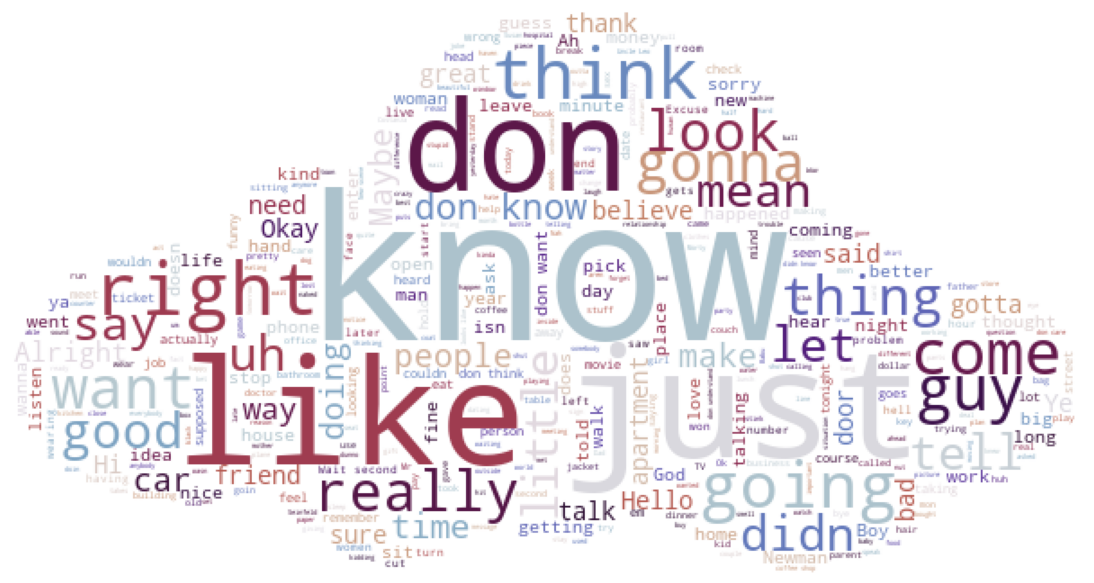

In [70]:
jerry_text = combine_lines(jerry, 'line_no_par')

wordcloud_jerry = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='white', 
                      colormap='twilight', 
                      collocations=True, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(jerry_text)

plot_cloud(wordcloud_jerry, 'jerry')

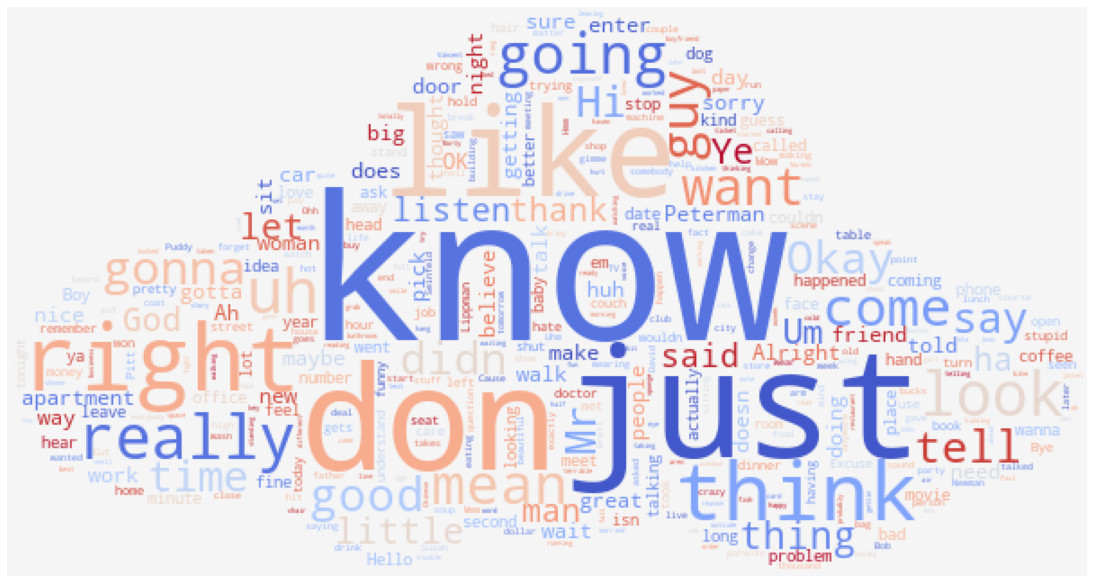

In [71]:
elaine_text = combine_lines(elaine, 'line_no_par')

wordcloud_elaine = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='whitesmoke', 
                      colormap='coolwarm', 
                      collocations=False, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(elaine_text)

plot_cloud(wordcloud_elaine, 'elaine')

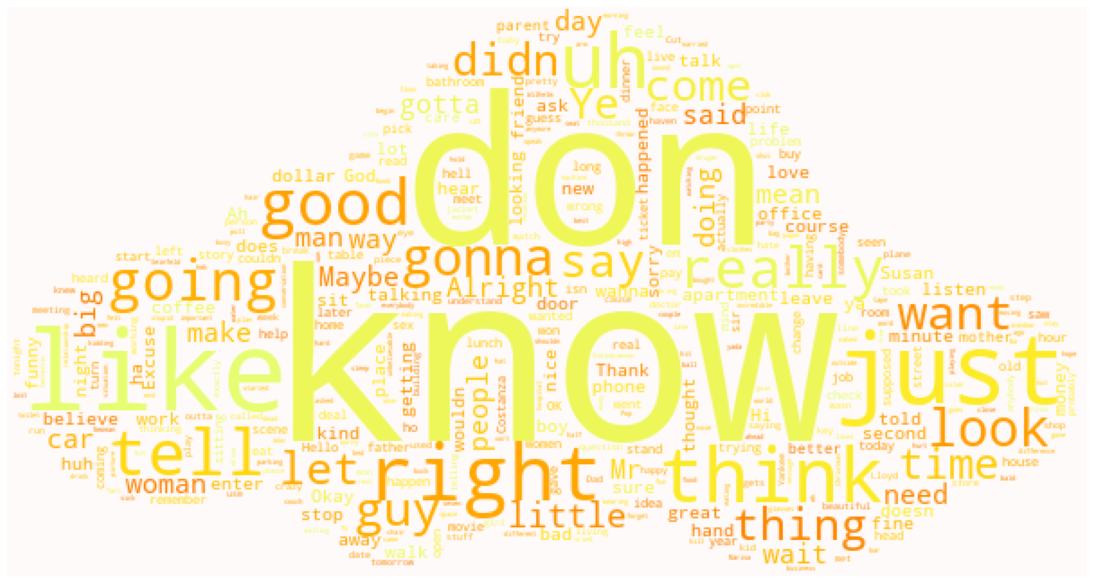

In [72]:
george_text = combine_lines(george, 'line_no_par')

wordcloud_george = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='snow', 
                      colormap='Wistia', 
                      collocations=False, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(george_text)

plot_cloud(wordcloud_george, 'george')

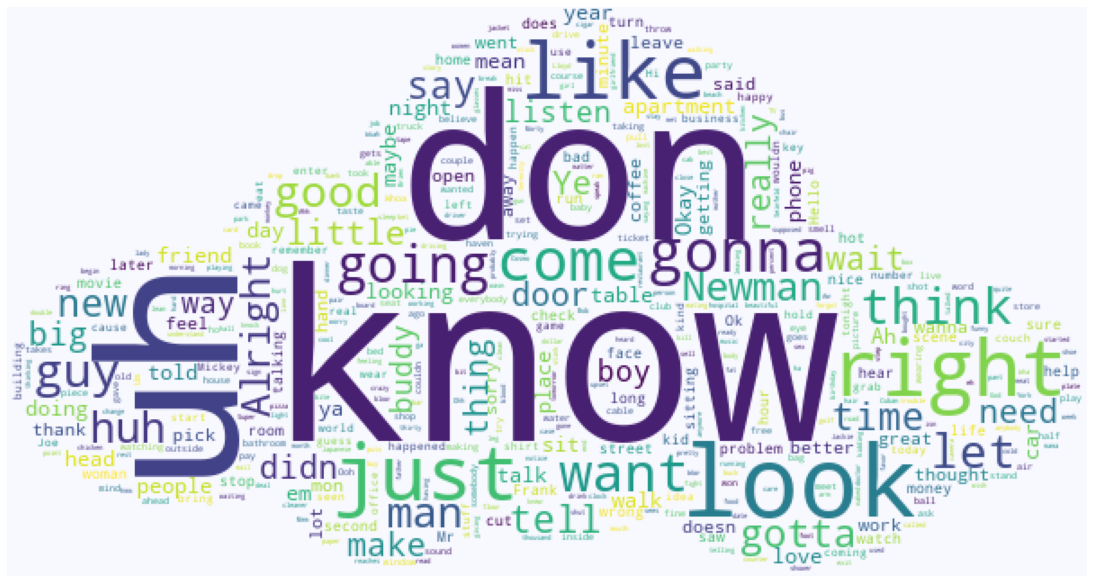

In [73]:
kramer_text = combine_lines(kramer, 'line_no_par')

wordcloud_kramer = WordCloud(width=2000, 
                      height=1600, 
                      random_state=42, 
                      max_words=1000,
                      regexp=r'\b\w\w+\b',
                      background_color='ghostwhite', 
                      colormap='viridis', 
                      collocations=False, 
                      stopwords = stop_words_uni,
                      mask=mask).generate(kramer_text)

plot_cloud(wordcloud_kramer, 'kramer')

### Finalizing Data

In [74]:
df = pd.DataFrame(data=scripts['char_line'])
df.head()

,char_line
0,"jerry: you know, why we're here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about ""we should go out""? this is what they're talking about...this whole thing, we're all out now, no one is home. not one person here is home, we're all out! there are people tryin' to find us, they don't know where we are. (imitates one of these people ""tryin' to find us""; pretends his hand is a phone) ""did you ring?, i can't find him."" (imitates other person on phone) ""where did he go?"" (the first person again) ""he didn't tell me where he was going"". he must have gone out. you wanna go out: you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...there you're staring around, whatta you do? you go: ""we gotta be getting back"". once you're out, you wanna get back! you wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? where ever you are in life, it's my feeling, you've gotta go. (pete's luncheonette. jerry and george are sitting at a table.)"
1,"jerry: seems to me, that button is in the worst possible spot. (talking about george's shirt) the second button literally makes or breaks the shirt, look at it: it's too high! it's in no-man's-land, you look like you live with your mother."
2,george: are you through? (kind of irritated)
3,"jerry: you do of course try on, when you buy?"
4,"george: yes, it was purple, i liked it, i don't actually recall considering the buttons."


In [75]:
df.to_csv('../data/for_train.csv')

texts='\n'.join(df['char_line'])

with open('../data/for_train.txt', 'w') as f:
    f.write(texts)